The purpose of this project is to get some hands-on experience implementing nonparametric algorithms to perform classification and regression. Specifically, we will be implementing a 𝑘-nearest neighbor classifier and regressor. Dataset “Breast Cancer,” a dataset from the UCI Machine Learning repository, for use in classification tasks.

In [1]:
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
import warnings
from collections import Counter
from scipy.stats import mode

sns.set(style="whitegrid")

In [2]:
warnings.filterwarnings("ignore")

In [3]:
THEME = "SteelBlue"

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
df = pd.read_csv("Data//breast-cancer-wisconsin.data",header=None)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [7]:
df.columns = ["Sample code number","Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape",
              "Marginal Adhesion","Single Epithelial Cell Size","Bare Nuclei","Bland Chromatin","Normal Nucleoli",
              "Mitoses","Class"]

In [8]:
df

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


We see that the Bare Nuclei attribute has missing values. Let's remove the observations with missing values

In [9]:
df = df[df["Bare Nuclei"] != "?"]

In [10]:
df["Bare Nuclei"] = pd.to_numeric(df["Bare Nuclei"])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


In [12]:
df["Class"] = df["Class"].replace({2: 0, 4: 1})

We will now start with building our own KNN classifier. The first step is to split the data to testing and tunning sets. While splitting the data we will ensure the presence of both the classes are maintained.

In [13]:
def split_data(data, split_percentage, target):
    
        split_data = {}
        target_values = data[target]

        # first check the ratio of different values in target
        # distinct labels/classes in the target feature
        classes = list(Counter(target_values).keys())

        # value count for each classes
        distinct_class_counts = list(Counter(target_values).values())

        # allocates how many items to be available in bin based their availability percentage in original data
        # e.g. True: 65, False: 35 for bin size 100
        class_counts_list = []

        for index in range(0, len(split_percentage)):
            current_bin_size = int(np.round(len(data) * split_percentage[index] / 100))
            class_counts = {}
            for inner_index in range(0, len(classes)):
                class_counts[classes[inner_index]] = int(round(
                    distinct_class_counts[inner_index] / len(data) * current_bin_size))
            class_counts_list.append(class_counts)

            split_data[index] = pd.DataFrame()
            class_counts = class_counts_list[index]
            for key in class_counts:
                # data belong to one class
                jump = class_counts_list[index - 1][key] if index > 0 else 0
                data_to_pick_from = data.loc[data[target] == key]
                max_class_items = class_counts[key]
                # data belong to one class excluding already binned in earlier bins.
                # i.e. data available to put in right bin
                data_to_add = data_to_pick_from[jump: jump + max_class_items]
                split_data[index] = split_data[index].append(data_to_add)
                
        return split_data

In [14]:
split_percentage = [20, 80]
split_df = split_data(df,split_percentage, 'Class')

In [15]:
tuning_set = split_df[0]
testing_set = split_df[1]

In [16]:
tuning_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 105
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           137 non-null    int64
 1   Clump Thickness              137 non-null    int64
 2   Uniformity of Cell Size      137 non-null    int64
 3   Uniformity of Cell Shape     137 non-null    int64
 4   Marginal Adhesion            137 non-null    int64
 5   Single Epithelial Cell Size  137 non-null    int64
 6   Bare Nuclei                  137 non-null    int64
 7   Bland Chromatin              137 non-null    int64
 8   Normal Nucleoli              137 non-null    int64
 9   Mitoses                      137 non-null    int64
 10  Class                        137 non-null    int64
dtypes: int64(11)
memory usage: 12.8 KB


In [17]:
testing_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 163 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           546 non-null    int64
 1   Clump Thickness              546 non-null    int64
 2   Uniformity of Cell Size      546 non-null    int64
 3   Uniformity of Cell Shape     546 non-null    int64
 4   Marginal Adhesion            546 non-null    int64
 5   Single Epithelial Cell Size  546 non-null    int64
 6   Bare Nuclei                  546 non-null    int64
 7   Bland Chromatin              546 non-null    int64
 8   Normal Nucleoli              546 non-null    int64
 9   Mitoses                      546 non-null    int64
 10  Class                        546 non-null    int64
dtypes: int64(11)
memory usage: 51.2 KB


Now we have split the data into 20% and 80%. We will now do the hyper parameter tunning to get the best k value for our KNN classifier.

In [18]:
def get_k_folded_data(input_data, k, target):

        k_fold_data = {}

        bin_size = np.round(len(input_data) / k)

        #target_index = input_data.columns.index(target)
        target_values = input_data[target]

        # for classification task
       
        # first check the ratio of different values in target
        # distinct labels/classes in the target feature
        classes = list(Counter(target_values).keys())

        # value count for each classes
        distinct_class_counts = list(Counter(target_values).values())

        # allocates how many items to be available in bin based their availability percentage in original data
        # e.g. True: 65, False: 35 for bin size 100

        class_counts = {}
        for inner_index in range(0, len(classes)):
            class_counts[classes[inner_index]] = int(round(
                distinct_class_counts[inner_index] / len(input_data) * bin_size))

        for index in range(0, k):
            k_fold_data[index] = pd.DataFrame()
            for key in class_counts:
                # data belong to one class
                jump = index * class_counts[key]  # if index > 0 else 0
                data_to_pick_from = input_data.loc[input_data[target] == key]
                max_class_items = class_counts[key]

                # data belong to one class excluding already binned in earlier bins.
                data_to_add = data_to_pick_from[jump: jump + max_class_items]
                k_fold_data[index] = k_fold_data[index].append(data_to_add)
            k_fold_data[index] = k_fold_data[index].reset_index(drop=True)

        return k_fold_data

In [19]:
k = 5
k_fold_data = get_k_folded_data(tuning_set, k, 'Class')

In [20]:
def get_euclidean_distance(X, Y):
    
    distance = np.sqrt(np.sum(np.square([float(x_i) - float(y_i) for x_i, y_i in zip(X, Y)])))
    return distance

In [21]:
def predict(testing_set, training_set, target, k):
        
    predicted_classes = []
    data_index = 0
    while data_index < len(testing_set):
        
        #print(testing_set.iloc[26])
        
        xq = testing_set.iloc[data_index, training_set.columns != target]

        distance_data = np.array(
            [[index, get_euclidean_distance(xq, datum[training_set.columns != target]), datum[target]]
             for index, datum in training_set.iterrows()])

        distance_data = distance_data[distance_data[:, 1].argsort()]
        # voted points
        selected_neighbors = distance_data[:k]

        # Classes of the K datapoints from above
        labels = selected_neighbors[:, 2]

        # Majority voting
        lab = mode(labels)
        lab = lab.mode[0]
        predicted_classes.append(lab)

        data_index += 1

    return predicted_classes

In [22]:
def plot(x, y, title, x_label, y_label):

    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


In [23]:
def tune_knn_voting_classification(k_fold_data, target, possible_k_values):

    misclassification_rate_per_k = []

    for k in possible_k_values:
        misclassification_count = 0
        total_data_count = 0

        for index in range(0, len(k_fold_data)):
            validation_set = k_fold_data[index]
            total_data_count += len(validation_set)
            # take all folds except index fold
            #training_set = [value for key, value in k_fold_data.items() if key not in [index]]
            
            training_set = pd.DataFrame()
            for key, fold_data in k_fold_data.items():
                if key != index:
                    training_set = training_set.append(k_fold_data[key])   

            # Combine all folds except index fold as one dataset
            #training_set = np.array([item for sublist in training_set for item in sublist])
            predicted_classes = predict(validation_set, training_set, target, k)

            misclassification_count += len(
                [
                    val for index, val in enumerate(validation_set[target]) if
                 predicted_classes[index] != validation_set[target][index]
                ])

        misclassification_rate = np.round(misclassification_count / total_data_count, 4)
        misclassification_rate_per_k.append(misclassification_rate)

    plot(possible_k_values, misclassification_rate_per_k, 'k Hyperparmeter Performance', 'k',
              'Misclassification Rate')
        
    index_min_error_rate = np.argmin(misclassification_rate_per_k)
    best_k_value = possible_k_values[index_min_error_rate]

    return best_k_value

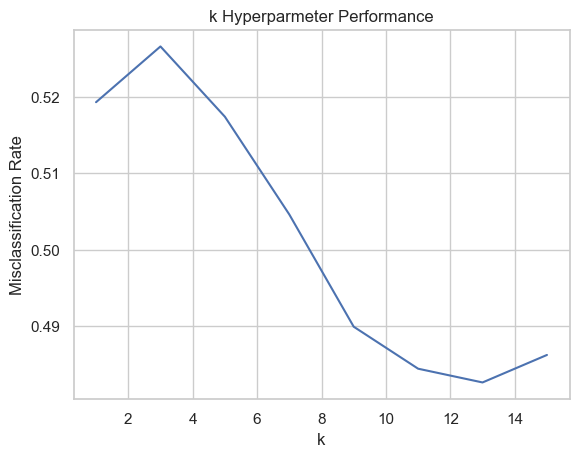


best_k = 13


In [40]:
possible_k_values = [1, 3, 5, 7, 9, 11, 13, 15]
best_k = tune_knn_voting_classification(k_fold_data, 'Class', possible_k_values)
print('best_k = ' + str(best_k))

In [25]:
# actual k-fold cross validation , 80% data
k_fold_data = get_k_folded_data(testing_set, k, 'Class')

In [38]:
def knn_voting_classification(k_fold_data, target, k):

    misclassification_count = 0
    total_data_count = 0
    for index in range(0, len(k_fold_data)):
        testing_set = k_fold_data[index]
        total_data_count += len(testing_set)

        # take all folds except index fold
        training_set = pd.DataFrame()
        for key, fold_data in k_fold_data.items():
            if key != index:
                training_set = training_set.append(k_fold_data[key])   

        predicted_classes = predict(testing_set, training_set, target, k)

        misclassification_count += len(
                [
                    val for index, val in enumerate(testing_set[target]) if
                 predicted_classes[index] != testing_set[target][index]
                ])

    misclassification_rate = np.round(misclassification_count / total_data_count, 4)

    return misclassification_rate

In [39]:
error_rate = knn_voting_classification(k_fold_data, "Class", best_k)
print(error_rate)

0.4569
